<a href="https://www.kaggle.com/code/annaattuch/dlip-notebook-group-4?scriptVersionId=284957225" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color:#5F9EA0; 
            color:white; 
            padding:15px; 
            border-radius:10px; 
            text-align:center; 
            font-size:30px; 
            font-weight:bold;">
    Detecting Deep Fakes - A Deep Learning Computer Vision Task<br>
    <span style="font-size:20px; font-weight:normal;">
        Hairy Feet: Anna, Jacob, Johannes
    </span>
</div>

<h1 id = setup style = 'font-size:30px; background: linear-gradient(90deg, #5F9EA0, #7AC5CD, #8EE5EE); color: white; padding: 10px;  border-radius: 10px;'>
    1. Introduction: Project Overview & Data 
</h1

<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
In this project, we build a deep learning computer vision model to distinguish between real human faces, and AI-generated (deepfake) face images. 

We use the **DeepDetect-2025** dataset from Kaggle, which contains over 100k labeled images of faces, split into two classes: real and fake. The goal is to train a binary classifier that can automatically detect whether an image is genuine or AI generated.

# 2. Methods

## 2.1 Importing and Preparing Data

In [30]:
import kagglehub

# Download DeepDetect-2025 dataset
path = kagglehub.dataset_download("ayushmandatta1/deepdetect-2025")

print("Path to dataset files:", path)

# Download CIFAKE dataset (for later use)
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/deepdetect-2025
Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>

The DeepDetect-2025 dataset is organized into separate "train" and "test" folders, each containing two subfolders:

- "real" = real human face images  
- "fake" = AI-generated (deepfake) face images  

We will:
- Set a fixed image size and batch size
- Point TensorFlow to the "train" and "test" directories


In [31]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

deepdetect_train_dir = "/kaggle/input/deepdetect-2025/ddata/train"
deepdetect_test_dir  = "/kaggle/input/deepdetect-2025/ddata/test"



<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
Now we create the training, validation and test sets. 
We use tf.keras.utils.image_dataset_from_directory to:

- Load images from the "train"  directory
- Automatically split the training data into:
  - **80% training**
  - **20% validation**

The images in the "test" directory are used as a separate held-out test set that we will only use for final evaluation.

In [32]:

train_dd = tf.keras.utils.image_dataset_from_directory(
    deepdetect_train_dir,
    validation_split=0.2,      
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dd = tf.keras.utils.image_dataset_from_directory(
    deepdetect_train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dd = tf.keras.utils.image_dataset_from_directory(
    deepdetect_test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False    
)


Found 90409 files belonging to 2 classes.
Using 72328 files for training.
Found 90409 files belonging to 2 classes.
Using 18081 files for validation.
Found 21776 files belonging to 2 classes.


## 2.2 Data Exploration and Visualisation

### 2.2.1 Show sample images from the training dataset
We visualize sample images by taking the first batch from the training dataset. Since the dataset is shuffled on loading, each batch is a random collection of images. From this batch, we display the first 9 images in a 3×3 grid along with their corresponding class labels (“real” or “fake”).

We do this to perform an initial quality check of the dataset: visual inspection allows us to confirm that the images were loaded correctly, that the labels correspond to the expected classes, and that there are no obvious issues such as corrupted files, incorrect preprocessing, or mislabeled images. Showing random samples also helps us get an intuitive understanding of what the model will see during training and whether the dataset contains sufficient visual variability for effective learning.

Class names: ['fake', 'real']


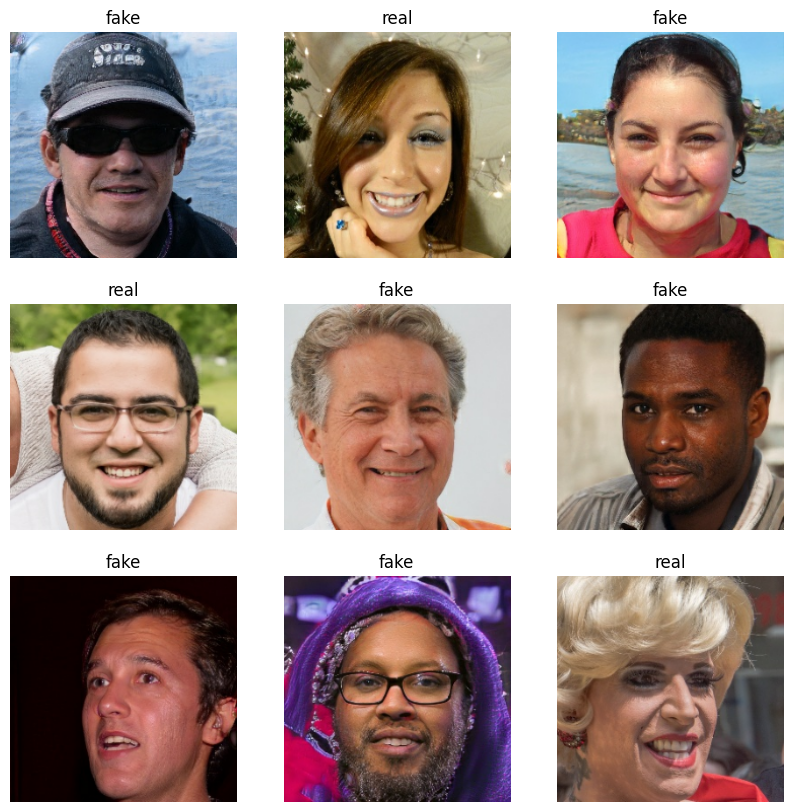

In [33]:
import matplotlib.pyplot as plt         
import numpy as np            
import os   

class_names = train_dd.class_names     
print("Class names:", class_names)      

plt.figure(figsize=(10, 10))            

for images, labels in train_dd.take(1):  

 for i in range(9):                   
        ax = plt.subplot(3, 3, i + 1)  
        plt.imshow(images[i].numpy().astype("uint8"))   
        plt.title(class_names[labels[i]])              
        plt.axis("off")                                 

plt.show()                             


### 2.2.2 Check class distribution
We assess the class distribution by counting how many images belong to each category (“real” and “fake”). A balanced dataset is important because severe class imbalance can bias the model toward predicting the majority class. By examining the distribution visually and numerically, we ensure that the model will be trained on approximately equal amounts of real and AI-generated images, reducing the risk of skewed learning or misclassification patterns.

Number of training images:
Real: 48815
Fake: 41594


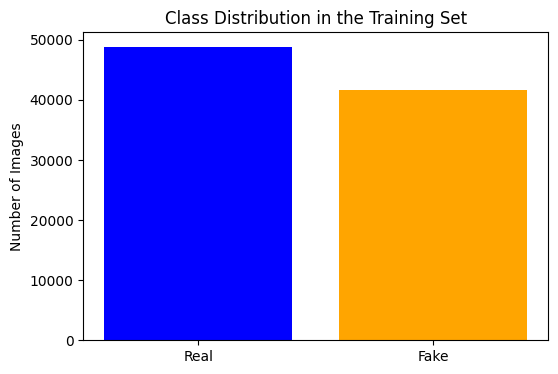

In [34]:
train_real = len(os.listdir(os.path.join(deepdetect_train_dir, "real")))
train_fake = len(os.listdir(os.path.join(deepdetect_train_dir, "fake")))

print("Number of training images:")
print("Real:", train_real)
print("Fake:", train_fake)

plt.figure(figsize=(6, 4))
plt.bar(["Real", "Fake"], [train_real, train_fake], color=["blue", "orange"])
plt.title("Class Distribution in the Training Set")
plt.ylabel("Number of Images")
plt.show()

### 2.2.3 Inspect Image Shape and Label Format
We inspect the shape of one batch to verify that the images and labels are formatted as expected. The image batch typically has the shape (batch_size, height, width, channels) e.g., (32, 224, 224, 3), indicating 32 RGB images of size 224×224 pixels.

The label batch should have the shape (batch_size,), containing one integer label per image. Confirming these shapes helps ensure that the data pipeline is correctly configured before building the neural network model.

In [35]:
for batch_images, batch_labels in train_dd.take(1):
    print("Image batch shape:", batch_images.shape)
    print("Label batch shape:", batch_labels.shape)
    print("Example label:", batch_labels[0].numpy())
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Example label: 1


The batch shape (32, 224, 224, 3) confirms that images are correctly loaded in batches of 32, each resized to 224×224 pixels with three RGB channels. The label batch (32,) shows that each image has one corresponding class label. The example label 0/1 indicates that the labeling system is functioning as expected and correctly maps images to their respective classes. Overall, the data pipeline is properly structured for model training.

## 2.3 Data Preprocessing

### 2.3.1 Data Augmentation
We apply data augmentation to artificially increase the variability of the training dataset and improve the model’s ability to generalize. The augmentation pipeline randomly flips, rotates, and zooms images during training, introducing meaningful variations that help the model become more robust to common transformations. This reduces overfitting and improves performance on unseen data.


In [36]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   
    tf.keras.layers.RandomRotation(0.1),        
    tf.keras.layers.RandomZoom(0.1),            
], name="data_augmentation")

### 2.3.2 Visualizing Data Augmentation
We visualize a batch of augmented images to verify that the applied transformations (flipping, rotation, and zoom) behave as intended and produce realistic variations. This quick inspection ensures that augmentation does not distort the data in a harmful way and confirms that the model will receive meaningful, correctly transformed inputs during training.

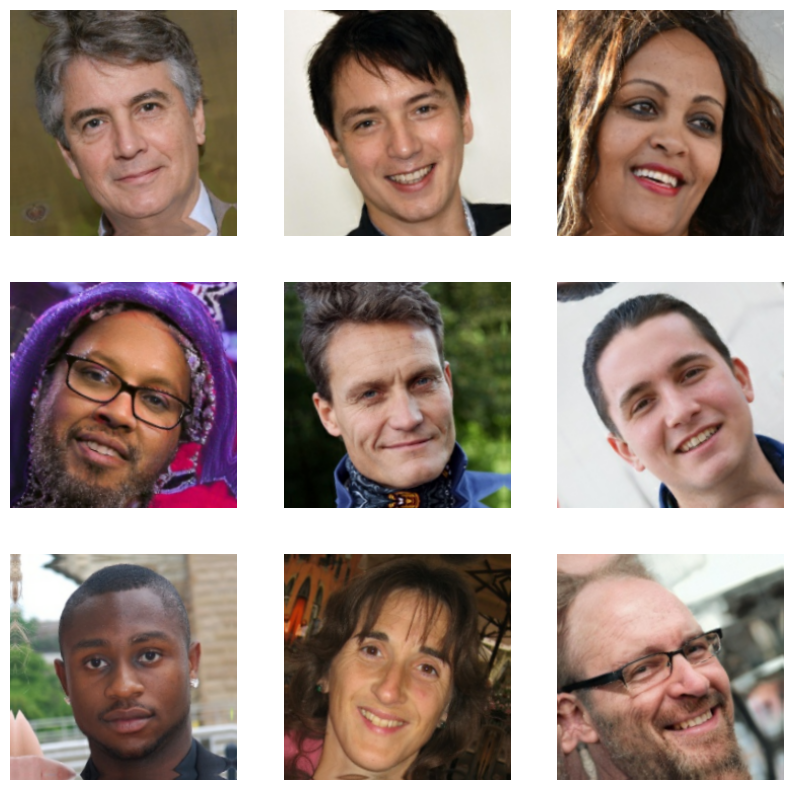

In [37]:
for images, labels in train_dd.take(1):
    augmented = data_augmentation(images)
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

## 2.4 Neural Models

### 2.4.1 Custom CNN

**Architecture**

In [38]:
from tensorflow import keras
from tensorflow.keras import layers

# Custom-made CNN classifier 
custom_cnn = keras.Sequential([

    # First convolution + maxpool block (32 filters)
    layers.Conv2D(filters=32, kernel_size=3, padding='same',
                 input_shape=(224, 224, 3)),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Second convolution + maxpool block (64 filters)
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Third convolution + maxpool block (128 filters)
    layers.Conv2D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    #Fourth convolution + maxpool block (256 filters)
    layers.Conv2D(filters=256, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),
    # removed maxpool to preserve fine-grained details

    # Global average pooling block
    layers.GlobalAveragePooling2D(),

    # Fully connected block
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
    
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 2.4.2 Pre-trained CNN

**Architecture**



In [39]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras import Model

# Load the base model with ImageNet weights, excluding the top classifier
base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze the base model layers
base_model.trainable = False

# Create the input layer for the whole model
inputs = layers.Input(shape=(224,224,3))

# Pass the input through the frozen base model
x = base_model(inputs, training=False)

# Attach the new classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3, name="top_dropout")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Create the final model
efficientnet_model = Model(inputs, outputs, name="EfficientNetB4_FineTuner")

# For future fine-tuning

"""
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers except the last ~20% of the model (e.g., last two blocks of EfficientNet)
for layer in base_model.layers[:-40]: # Adjust the number of layers to unfreeze
    layer.trainable = False
"""

'\n# Unfreeze the base model\nbase_model.trainable = True\n\n# Freeze all layers except the last ~20% of the model (e.g., last two blocks of EfficientNet)\nfor layer in base_model.layers[:-40]: # Adjust the number of layers to unfreeze\n    layer.trainable = False\n'

### 2.4.3 Visual Transformer

**Architecture**

In [40]:
from transformers import TFViTForImageClassification, ViTImageProcessor

# Define the input shape 
IMG_SIZE = 224
MODEL_NAME = 'google/vit-base-patch16-224'

# Load the base model including the classification head (customized for our task)

vit_model_with_head = TFViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, # Two classes: Real and Fake
    id2label={0: 'REAL', 1: 'FAKE'},
    ignore_mismatched_sizes=True 
)

# Freeze the entire encoder
for layer in vit_model_with_head.layers:
    layer.trainable = False

# Load the associated image processor to define required preprocessing
processor = ViTImageProcessor.from_pretrained(MODEL_NAME)
target_size = processor.size['height'] # Should be 224

# Keras Function to apply ViT preprocessing
def preprocess_image(image):
    # Resize and normalize according to ViT standards
    image = tf.image.resize(image, (target_size, target_size))
    # ViT usually expects pixels to be in the range [0, 1] then normalized 
    # (The TFViTForImageClassification handles the normalization internally after the input)
    image = image / 255.0 # Basic scaling [0, 1]
    return image


# You should map this function over your tf.data.Dataset object.
# train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

## 2.5 Fitting


# 3. Results

# 4. Conclusion/Discussion

# 5. References

# 6. Division of Labour